# IDENTIFICATION USING BOTH SURROGATE MODELS - COARSE AND FINE
#  INCREASED NOISE

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [2]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

sys.path.append('../../tests/Xaccelerometer_geometric/models')




Ray module not found. Multiprocessing features are not available


### Define some helping functions 

In [3]:
def plot_results(time, y_true, y_obs, model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(x_true), 'black', label = 'True parameters')
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [4]:
def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean, mode = np.mean(parameter_samples), x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

#### Decide sample to use for experimental data

In [5]:
sample = 110 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [6]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 10000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2
print( 'The standard deviation of the noise is: ', noise)


The standard deviation of the noise is:  0.4999999999999999


#### Load Surrogate Models

Load fine model 

In [7]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Load Fine model 
# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])
# Define forward and gradient functions for the first configuration
fine_model = create_forward_model_function(data_processor_I, model_I)

Load coarse model 

In [8]:
# Import the function coarse_model
from coarse_model import *

num_samples = 640
num_parameters = 3
num_coarse_values = 75
# Define the neural network model
model_lowfidelity_NN = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])
# Load the model
model_lowfidelity_NN = load_model('./models/model_LF_NN_oo3.keras')
model_lf = create_model_LF_NN_oo3_opt()

/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


load the data 

In [9]:
# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

### Define Priors and Likelyhoods

 Define a custom Uniform random variable class

In [10]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if  self.pdf(x)==0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [11]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time))
y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood) 

#points = np.linspace(0,0.0015-1e-5,150)
#phi = lambda t: np.abs(np.cos(2*np.pi*2500*t)) if t < 2.25/2500 and t > 0.25/2500 else 0
#coeff = [1+10*phi(t-1e-5*10) for t in points]
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10)

### Define a Posterior

In [12]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, coarse_model)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]



#### Perform least square optimization for each starting point

In [13]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=fine_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")

# covariance_matrix = np.eye(3)*(np.diag(covariance_matrix))
print('\nWe are using the following covariance matrix\n', covariance_matrix)


Real Params:  [ 0.317228  0.314022 30.854021]
Optimized Params 1: [ 0.31799997  0.31784666 30.52424523]
Optimized Params 2: [ 0.31555037  0.32322243 29.81426893]
Optimized Params 3: [ 0.31623107  0.32215715 29.96659022]
Optimized Params 4: [ 0.31539283  0.32330043 29.7956225 ]
Optimized Params 5: [ 0.31556687  0.32329697 29.80808397]

We are using the following covariance matrix
 [[ 5.92547113e-05 -4.66058537e-05  8.70615775e-03]
 [-4.66058537e-05  2.46835957e-04 -2.75172453e-02]
 [ 8.70615775e-03 -2.75172453e-02  3.31368573e+00]]


Set up the proposal

In [14]:
# Adaptive Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.2)


#### Do Metropolis Hastings Sampling - MDA

In [16]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                             iterations=2100, n_chains=1,
                               initial_parameters=initial_guess, 
                           subsampling_rate = 30) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(100, None, 3), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])

end_0 = timeit.default_timer() 
# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 

print("\nThe average ESS is: ", np.mean(ESS_values, axis = 0 ) ) 
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0) ))

# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  



Sampling chain 1/1


Running chain, α_c = 0.789, α_f = 0.49: 100%|██████████| 2100/2100 [00:12<00:00, 174.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 270.5
    Offset     float64 8B 346.4
    Thickness  float64 8B 399.1 

Sampling chain 1/1


Running chain, α_c = 0.785, α_f = 0.37: 100%|██████████| 2100/2100 [00:11<00:00, 186.67it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 255.8
    Offset     float64 8B 355.7
    Thickness  float64 8B 444.9 

Sampling chain 1/1


Running chain, α_c = 0.782, α_f = 0.39: 100%|██████████| 2100/2100 [00:11<00:00, 188.20it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 236.9
    Offset     float64 8B 328.1
    Thickness  float64 8B 383.8 

Sampling chain 1/1


Running chain, α_c = 0.787, α_f = 0.51: 100%|██████████| 2100/2100 [00:11<00:00, 178.84it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 353.3
    Offset     float64 8B 321.5
    Thickness  float64 8B 329.9 

Sampling chain 1/1


Running chain, α_c = 0.787, α_f = 0.47: 100%|██████████| 2100/2100 [00:11<00:00, 183.72it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 291.6
    Offset     float64 8B 440.8
    Thickness  float64 8B 497.4 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.004
    Offset     float64 8B 1.001
    Thickness  float64 8B 1.003

The average ESS is:  [281.63085715 358.4904211  410.99667132]
Time/ESS MDA [0.04113066 0.03231234 0.02818433]


# Diagnostics 

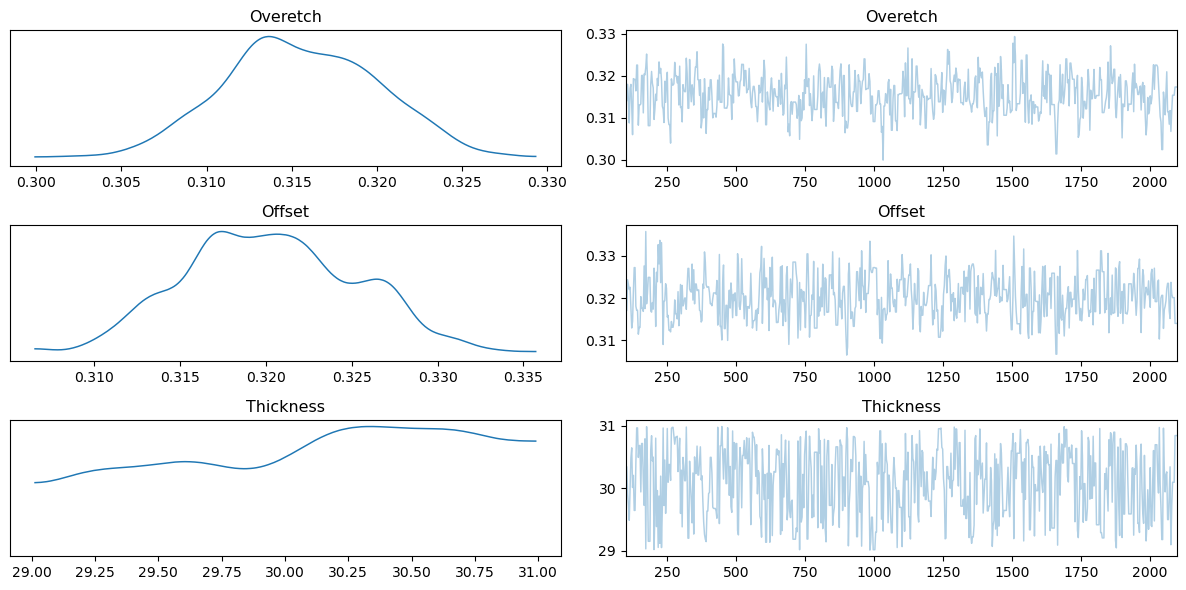

In [47]:
# Plot trace of the first set of samples
idata = samples_mh[0]
az.plot_trace(idata)
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

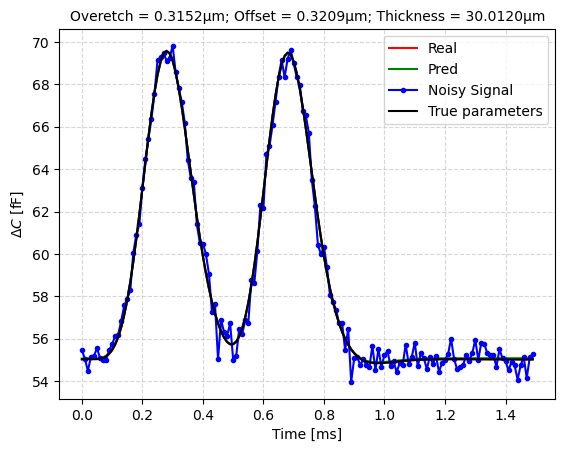

In [22]:
# Plotting and data collection
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, fine_model, data)

Finally, let's look at the parameters distribution

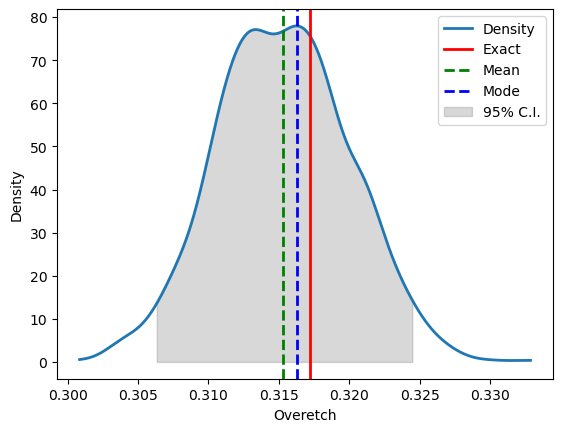

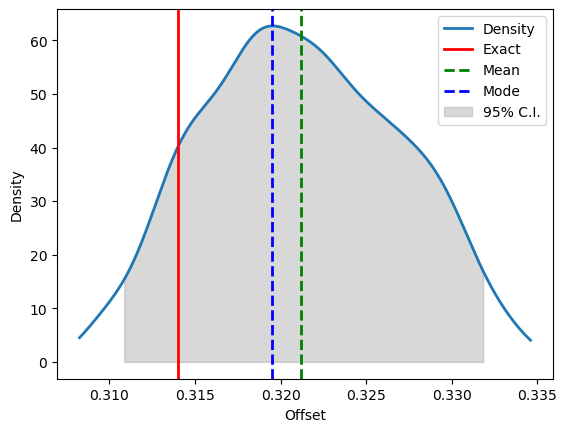

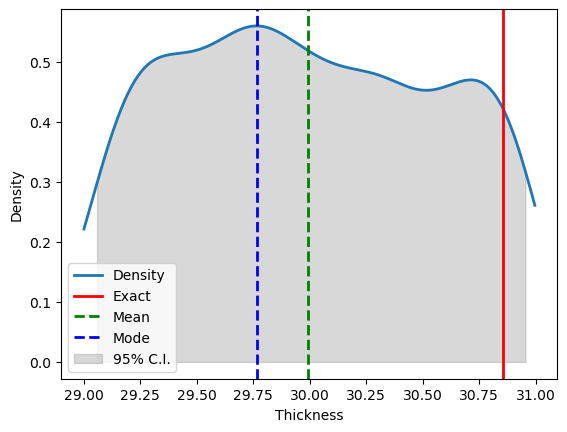

In [17]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

### Do Metropolis Hastings - FINE ONLY

In [20]:
my_proposal_fine = tda.GaussianRandomWalk(C=covariance_matrix, scaling = 0.8)

# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior_fine, my_proposal_fine, 
                             iterations=6000, n_chains=1,
                               initial_parameters=initial_guess) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(1000, None, 5), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 

print("\nThe average ESS is: ", np.mean(ESS_values, axis = 0 ) ) 
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0) ))
# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  



Sampling chain 1/1


Running chain, α = 0.17: 100%|██████████| 6000/6000 [00:22<00:00, 263.71it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 266.4
    Offset     float64 8B 375.9
    Thickness  float64 8B 398.2 

Sampling chain 1/1


Running chain, α = 0.33: 100%|██████████| 6000/6000 [00:22<00:00, 263.08it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 229.6
    Offset     float64 8B 326.3
    Thickness  float64 8B 368.5 

Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:23<00:00, 259.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 255.9
    Offset     float64 8B 252.6
    Thickness  float64 8B 468.0 

Sampling chain 1/1


Running chain, α = 0.34: 100%|██████████| 6000/6000 [00:22<00:00, 267.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 263.4
    Offset     float64 8B 339.7
    Thickness  float64 8B 322.3 

Sampling chain 1/1


Running chain, α = 0.24: 100%|██████████| 6000/6000 [00:23<00:00, 256.93it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 288.6
    Offset     float64 8B 328.8
    Thickness  float64 8B 380.6 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.003
    Offset     float64 8B 1.003
    Thickness  float64 8B 1.002

The average ESS is:  [260.77986302 324.67402442 387.53832956]
Time/ESS MDA [0.08790573 0.07060634 0.05915297]


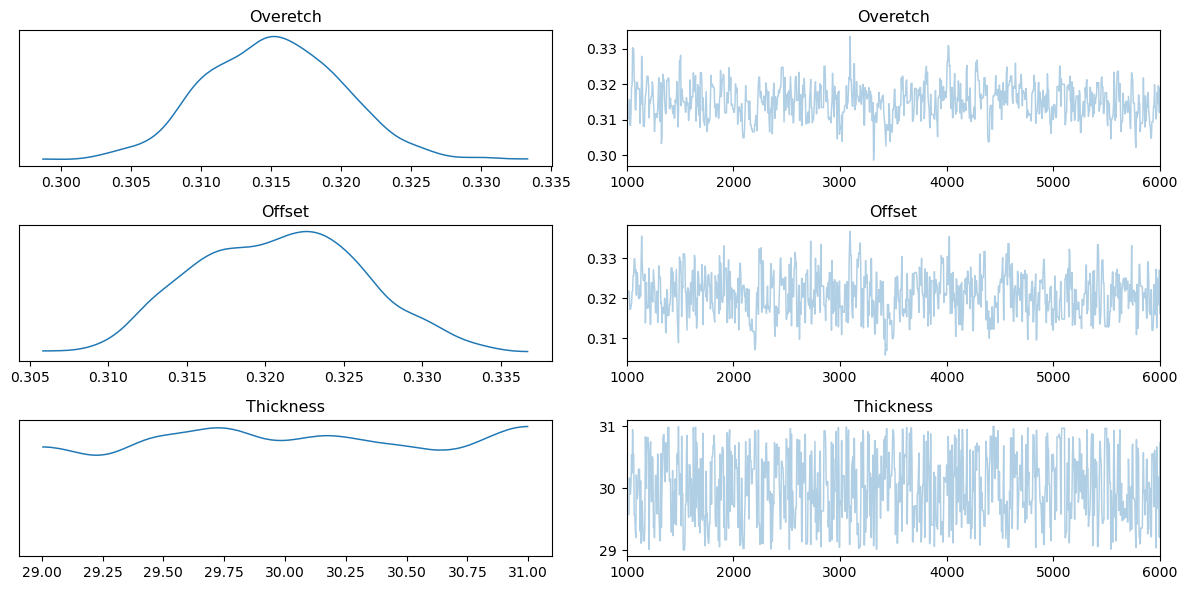

In [19]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

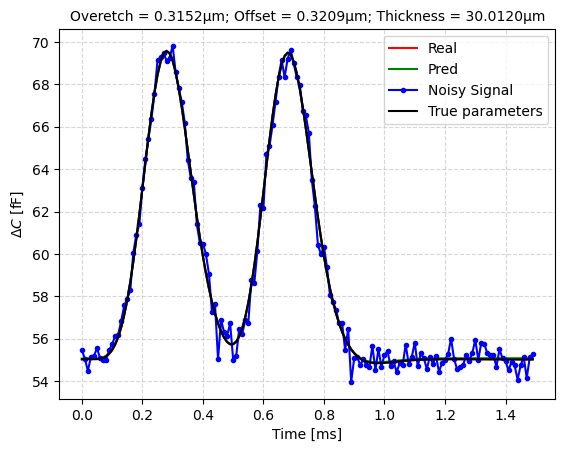

In [20]:
# Plotting and data collection
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, fine_model, data)

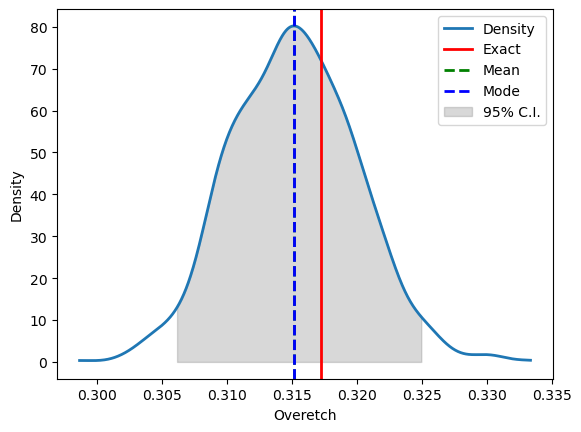

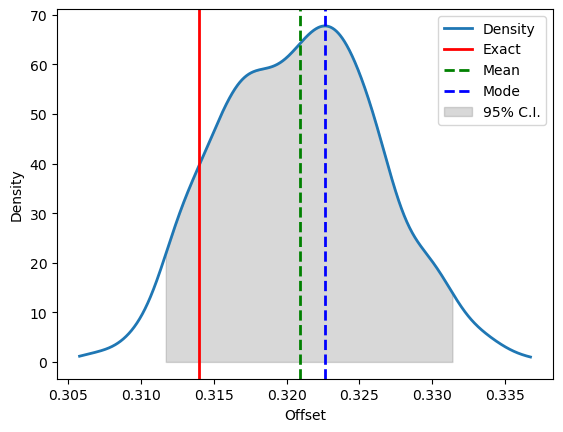

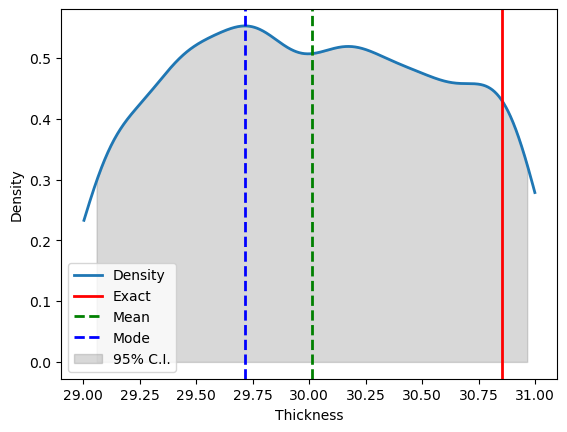

In [21]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Gridsearch ideal parameters 

In [42]:
subsampling_rate_values = [3, 5 , 10 , 20 , 30, 40 ]
scaling_values = [0.2, 0.3, 0.5, 0.7, 0.8, 1 ]

In [43]:
M = np.zeros((len(subsampling_rate_values), len(scaling_values)))


for index1, ssr in enumerate(subsampling_rate_values):
    for index2, scale in enumerate(scaling_values): 
        # Adaptive Metropolis
        my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
        # Initialize a list to hold the Effective sample sizes for each initial guess
        ESS_values = []
        # Iterate over each initial guess to set up and run the Markov chain sampler
        for index, initial_guess in enumerate(initial_guesses[0:2]):
            samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=4000, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = ssr)
                           #adaptive_error_model='state-independent')
            idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
            # Remove the burnin and sub-sample
            idata = idata.sel(draw=slice(250, None, 5), groups="posterior")
            ess = az.ess(idata)
            ESS_values.append((ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3)
            if(index==1):
                print('sampled with params: ', ssr, scale, '   done ', index2+1 + index1*len(scaling_values), '/', len(scaling_values)*len(subsampling_rate_values))

        # Add the mean of the different sample sizes to the matrix
        M[index1, index2] = np.mean(ESS_values)

Sampling chain 1/1


Running chain, α_c = 0.800, α_f = 0.66: 100%|██████████| 4000/4000 [00:11<00:00, 337.35it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.833, α_f = 0.77: 100%|██████████| 4000/4000 [00:12<00:00, 321.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.2    done  1 / 36
Sampling chain 1/1


Running chain, α_c = 0.703, α_f = 0.72: 100%|██████████| 4000/4000 [00:11<00:00, 338.99it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.703, α_f = 0.71: 100%|██████████| 4000/4000 [00:11<00:00, 340.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.3    done  2 / 36
Sampling chain 1/1


Running chain, α_c = 0.533, α_f = 0.49: 100%|██████████| 4000/4000 [00:11<00:00, 355.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.510, α_f = 0.50: 100%|██████████| 4000/4000 [00:11<00:00, 351.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.5    done  3 / 36
Sampling chain 1/1


Running chain, α_c = 0.420, α_f = 0.38: 100%|██████████| 4000/4000 [00:10<00:00, 386.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.383, α_f = 0.29: 100%|██████████| 4000/4000 [00:10<00:00, 366.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.7    done  4 / 36
Sampling chain 1/1


Running chain, α_c = 0.373, α_f = 0.25: 100%|██████████| 4000/4000 [00:10<00:00, 398.66it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.360, α_f = 0.27: 100%|██████████| 4000/4000 [00:10<00:00, 395.67it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.8    done  5 / 36
Sampling chain 1/1


Running chain, α_c = 0.290, α_f = 0.26: 100%|██████████| 4000/4000 [00:09<00:00, 430.21it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.323, α_f = 0.29: 100%|██████████| 4000/4000 [00:09<00:00, 439.38it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 1    done  6 / 36
Sampling chain 1/1


Running chain, α_c = 0.758, α_f = 0.76: 100%|██████████| 4000/4000 [00:13<00:00, 296.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.758, α_f = 0.64: 100%|██████████| 4000/4000 [00:12<00:00, 315.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.2    done  7 / 36
Sampling chain 1/1


Running chain, α_c = 0.676, α_f = 0.67: 100%|██████████| 4000/4000 [00:12<00:00, 318.81it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.692, α_f = 0.67: 100%|██████████| 4000/4000 [00:12<00:00, 323.46it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.3    done  8 / 36
Sampling chain 1/1


Running chain, α_c = 0.510, α_f = 0.45: 100%|██████████| 4000/4000 [00:12<00:00, 328.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.482, α_f = 0.49: 100%|██████████| 4000/4000 [00:12<00:00, 317.32it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.5    done  9 / 36
Sampling chain 1/1


Running chain, α_c = 0.458, α_f = 0.42: 100%|██████████| 4000/4000 [00:11<00:00, 346.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.420, α_f = 0.42: 100%|██████████| 4000/4000 [00:11<00:00, 344.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.7    done  10 / 36
Sampling chain 1/1


Running chain, α_c = 0.362, α_f = 0.33: 100%|██████████| 4000/4000 [00:11<00:00, 349.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.352, α_f = 0.35: 100%|██████████| 4000/4000 [00:11<00:00, 351.67it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.8    done  11 / 36
Sampling chain 1/1


Running chain, α_c = 0.294, α_f = 0.29: 100%|██████████| 4000/4000 [00:11<00:00, 352.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.268, α_f = 0.26: 100%|██████████| 4000/4000 [00:10<00:00, 371.72it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 1    done  12 / 36
Sampling chain 1/1


Running chain, α_c = 0.757, α_f = 0.56: 100%|██████████| 4000/4000 [00:13<00:00, 301.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.764, α_f = 0.66: 100%|██████████| 4000/4000 [00:13<00:00, 301.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.2    done  13 / 36
Sampling chain 1/1


Running chain, α_c = 0.675, α_f = 0.43: 100%|██████████| 4000/4000 [00:13<00:00, 295.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.704, α_f = 0.53: 100%|██████████| 4000/4000 [00:13<00:00, 287.26it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.3    done  14 / 36
Sampling chain 1/1


Running chain, α_c = 0.511, α_f = 0.39: 100%|██████████| 4000/4000 [00:13<00:00, 303.87it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.537, α_f = 0.40: 100%|██████████| 4000/4000 [00:13<00:00, 299.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.5    done  15 / 36
Sampling chain 1/1


Running chain, α_c = 0.408, α_f = 0.32: 100%|██████████| 4000/4000 [00:13<00:00, 302.53it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.398, α_f = 0.31: 100%|██████████| 4000/4000 [00:13<00:00, 295.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.7    done  16 / 36
Sampling chain 1/1


Running chain, α_c = 0.360, α_f = 0.28: 100%|██████████| 4000/4000 [00:13<00:00, 299.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.395, α_f = 0.38: 100%|██████████| 4000/4000 [00:13<00:00, 306.75it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.8    done  17 / 36
Sampling chain 1/1


Running chain, α_c = 0.283, α_f = 0.25: 100%|██████████| 4000/4000 [00:13<00:00, 294.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.316, α_f = 0.26: 100%|██████████| 4000/4000 [00:12<00:00, 312.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 1    done  18 / 36
Sampling chain 1/1


Running chain, α_c = 0.785, α_f = 0.53: 100%|██████████| 4000/4000 [00:15<00:00, 257.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.785, α_f = 0.44: 100%|██████████| 4000/4000 [00:15<00:00, 262.44it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.2    done  19 / 36
Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.26: 100%|██████████| 4000/4000 [00:15<00:00, 264.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.688, α_f = 0.33: 100%|██████████| 4000/4000 [00:15<00:00, 263.73it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.3    done  20 / 36
Sampling chain 1/1


Running chain, α_c = 0.517, α_f = 0.30: 100%|██████████| 4000/4000 [00:15<00:00, 254.22it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.545, α_f = 0.33: 100%|██████████| 4000/4000 [00:15<00:00, 258.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.5    done  21 / 36
Sampling chain 1/1


Running chain, α_c = 0.415, α_f = 0.29: 100%|██████████| 4000/4000 [00:15<00:00, 259.42it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.402, α_f = 0.25: 100%|██████████| 4000/4000 [00:15<00:00, 263.24it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.7    done  22 / 36
Sampling chain 1/1


Running chain, α_c = 0.360, α_f = 0.20: 100%|██████████| 4000/4000 [00:15<00:00, 256.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.374, α_f = 0.14: 100%|██████████| 4000/4000 [00:15<00:00, 265.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.8    done  23 / 36
Sampling chain 1/1


Running chain, α_c = 0.297, α_f = 0.19: 100%|██████████| 4000/4000 [00:15<00:00, 264.67it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.293, α_f = 0.16: 100%|██████████| 4000/4000 [00:15<00:00, 264.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 1    done  24 / 36
Sampling chain 1/1


Running chain, α_c = 0.784, α_f = 0.41: 100%|██████████| 4000/4000 [00:18<00:00, 218.90it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.785, α_f = 0.44: 100%|██████████| 4000/4000 [00:17<00:00, 225.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.2    done  25 / 36
Sampling chain 1/1


Running chain, α_c = 0.692, α_f = 0.30: 100%|██████████| 4000/4000 [00:17<00:00, 223.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.673, α_f = 0.30: 100%|██████████| 4000/4000 [00:18<00:00, 216.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.3    done  26 / 36
Sampling chain 1/1


Running chain, α_c = 0.531, α_f = 0.16: 100%|██████████| 4000/4000 [00:17<00:00, 225.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.534, α_f = 0.20: 100%|██████████| 4000/4000 [00:17<00:00, 229.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.5    done  27 / 36
Sampling chain 1/1


Running chain, α_c = 0.431, α_f = 0.12: 100%|██████████| 4000/4000 [00:17<00:00, 224.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.432, α_f = 0.12: 100%|██████████| 4000/4000 [00:17<00:00, 225.48it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.7    done  28 / 36
Sampling chain 1/1


Running chain, α_c = 0.344, α_f = 0.11: 100%|██████████| 4000/4000 [00:17<00:00, 231.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.371, α_f = 0.13: 100%|██████████| 4000/4000 [00:16<00:00, 235.38it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.8    done  29 / 36
Sampling chain 1/1


Running chain, α_c = 0.296, α_f = 0.11: 100%|██████████| 4000/4000 [00:17<00:00, 226.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.284, α_f = 0.12: 100%|██████████| 4000/4000 [00:17<00:00, 228.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 1    done  30 / 36
Sampling chain 1/1


Running chain, α_c = 0.784, α_f = 0.36: 100%|██████████| 4000/4000 [00:19<00:00, 203.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.783, α_f = 0.36: 100%|██████████| 4000/4000 [00:19<00:00, 201.63it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.2    done  31 / 36
Sampling chain 1/1


Running chain, α_c = 0.706, α_f = 0.21: 100%|██████████| 4000/4000 [00:19<00:00, 203.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.712, α_f = 0.28: 100%|██████████| 4000/4000 [00:19<00:00, 204.90it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.3    done  32 / 36
Sampling chain 1/1


Running chain, α_c = 0.540, α_f = 0.21: 100%|██████████| 4000/4000 [00:19<00:00, 202.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.539, α_f = 0.13: 100%|██████████| 4000/4000 [00:19<00:00, 204.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.5    done  33 / 36
Sampling chain 1/1


Running chain, α_c = 0.418, α_f = 0.16: 100%|██████████| 4000/4000 [00:19<00:00, 208.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.401, α_f = 0.13: 100%|██████████| 4000/4000 [00:19<00:00, 205.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.7    done  34 / 36
Sampling chain 1/1


Running chain, α_c = 0.370, α_f = 0.10: 100%|██████████| 4000/4000 [00:18<00:00, 210.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.379, α_f = 0.04: 100%|██████████| 4000/4000 [00:19<00:00, 208.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.8    done  35 / 36
Sampling chain 1/1


Running chain, α_c = 0.291, α_f = 0.05: 100%|██████████| 4000/4000 [00:19<00:00, 206.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.292, α_f = 0.12: 100%|██████████| 4000/4000 [00:18<00:00, 211.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 1    done  36 / 36


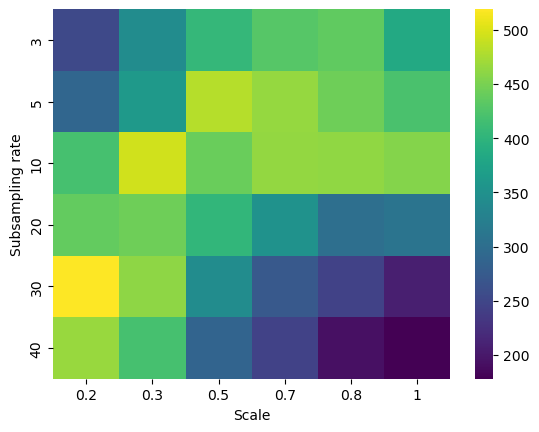

In [44]:
# Plot heatmap
sns.heatmap(M, cmap='viridis')
plt.xticks(ticks=np.arange(len(scaling_values)) + 0.5, labels=scaling_values)  # Adjust 0.5 offset if needed
plt.yticks(ticks=np.arange(len(subsampling_rate_values)) + 0.5, labels=subsampling_rate_values)  # Adjust 0.5 offset if needed
plt.xlabel('Scale')
plt.ylabel('Subsampling rate')
plt.show()